In [1]:
import pyro
import torch
import pyro.distributions as dist
from collections import OrderedDict
from typing import (
    Union,
)
import matplotlib.pyplot as plt

import chirho.contrib.compexp as ep  # TODO rename to expectation_programming (?)

pyro.settings.set(module_local_params=True)

PT = torch.nn.Parameter
TT = torch.Tensor
tt = torch.tensor
UPTT = Union[PT, TT]

## Minimizing Costs of Clean Energy Switch While Meeting Peak Load of Power Grid

A small country is planning to switch its power grid to clean energy. The grid will need to meet annual peak load, but the country would also like to minimize costs. Planners must contend with unknown polynomial scaling of cost, as the country's small size will require non-linear investments to squeeze more capacity out of limited power options.

These factors, however, are correlated — a strong economy will induce higher peak loads, but will also increase technological options to increase capacity.

Policy makers have two knobs to turn. The first is the capacity of the new power grid. The second is a direct investment in energy research and subsidies. This has the effect of reducing the effects of poor cost scaling and decreasing peak load needs due to efficiency.

In [2]:
def unmarginalized_model():

    # Latent economic factor in annual billions in GDP.
    # economic_strength = es = pyro.sample(
    #     "es",
    #     # dist.Normal(loc=100., scale=10.)
    #     dist.Delta(tt(100.))
    # )
    es = tt(100.)

    # Annual peak load in gigawatts.
    raw_peak_load = pyro.sample(
        "rpl", dist.Normal(loc=es / 10., scale=0.5))

    # Exponent of cost scaling per capacity.
    raw_cost_scaling = pyro.sample(
        "rcs", dist.Normal(loc=1. + 0.5 * (1. + ((100. - es) / 100.)), scale=0.1))

    return OrderedDict(
        rpl=raw_peak_load,
        rcs=raw_cost_scaling
    )

# marginal_rpl_rcs_samples = tt([list(unmarginalized_model().values()) for _ in range(20000)])
# marginal_rpl_rcs_mean = torch.mean(marginal_rpl_rcs_samples, dim=0)
# marginal_rpl_rcs_cov = torch.cov(marginal_rpl_rcs_samples.T)

In [3]:
# TODO this needs to trace out rpl and rcs.
# def model():
#     rplrcs = pyro.sample("rplrcs", dist.MultivariateNormal(
#         loc=marginal_rpl_rcs_mean, covariance_matrix=marginal_rpl_rcs_cov))
#
#     return OrderedDict(
#         rpl=rplrcs[0],
#         rcs=rplrcs[1]
#     )
model = unmarginalized_model

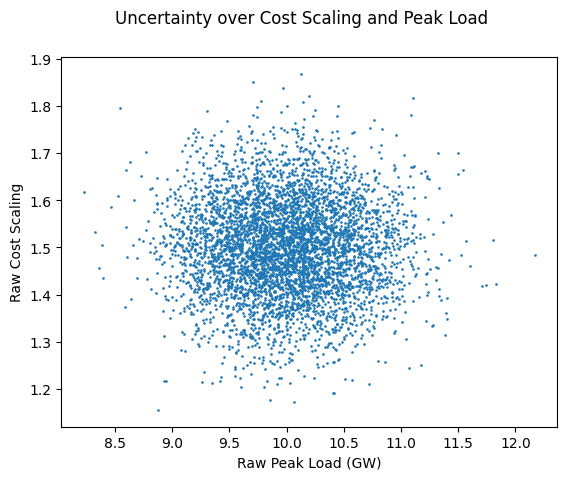

In [4]:
plt.figure()
plt.ylabel("Raw Cost Scaling")
plt.xlabel("Raw Peak Load (GW)")
plt.suptitle("Uncertainty over Cost Scaling and Peak Load")
plt.scatter(*tt([list(model().values()) for _ in range(5000)]).T, s=0.8)
plt.show()

In [5]:
def research_subsidy_outcome(subsidy_opportunity_cost):
    return 1. + torch.log(1. + torch.abs(subsidy_opportunity_cost))/30.

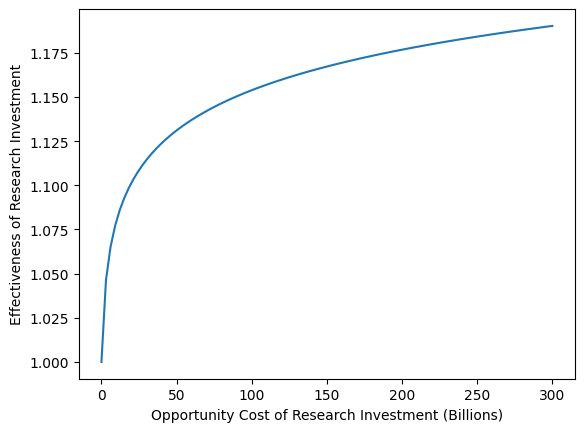

In [6]:
subsidy_val_xx = torch.linspace(0., 300., 100)
plt.ylabel("Effectiveness of Research Investment")
plt.xlabel("Opportunity Cost of Research Investment (Billions)")
plt.plot(subsidy_val_xx, research_subsidy_outcome(subsidy_val_xx))

In [7]:
# Cost in billions to build capacity for a scaled gigawatt.
COST_PER_SCALED_GW = tt(20.)

# Policy parameters: [
#   grid capacity (GW),
#   the opportunity cost (billions) arising from energy research subsidies
# ]
PP_OG = tt([7., 500.])
pp = PT(tt(PP_OG.detach().clone().numpy()))

def build_cost(policy_params):
    def cost_(plcs):
        adjusted_scaling = plcs["rcs"] / research_subsidy_outcome(policy_params[1])
        return policy_params[0] ** adjusted_scaling * COST_PER_SCALED_GW + policy_params[1]
    return cost_

cost = build_cost(pp)

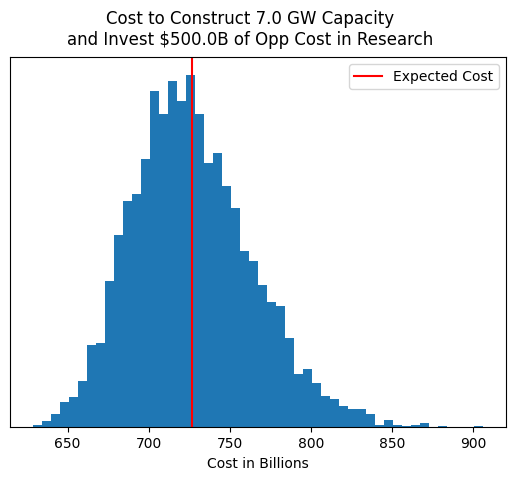

In [8]:
def plot_cost(policy_params):
    plt.figure()
    plt.suptitle(f"Cost to Construct {policy_params[0]} GW Capacity\n"
                 f"and Invest ${policy_params[1]}B of Opp Cost in Research")
    cost_samples = tt([cost(model()).detach() for _ in range(5000)])
    plt.hist(cost_samples, bins=50)
    plt.axvline(x=torch.mean(cost_samples), color='red', label=f"Expected Cost")
    plt.xlabel("Cost in Billions")
    plt.yticks([])
    plt.legend()
    plt.show()
plot_cost(pp)

#### Threshold on Penalized Expected Margin
As a first pass, the country will attempt to minimize costs while keeping the penalized, expected margin over peak load above some threshold.

In [9]:
def penalty(margin_val):
    return 1. - torch.exp(-margin_val)

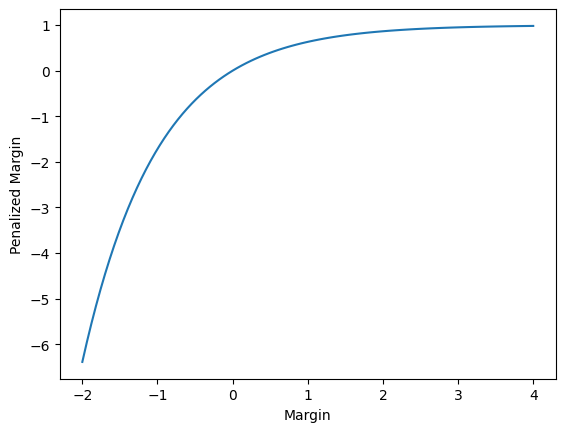

In [10]:
margin_val_xx = torch.linspace(-2., 4., 100)
plt.ylabel("Penalized Margin")
plt.xlabel("Margin")
plt.plot(margin_val_xx, penalty(margin_val_xx))

In [11]:
def build_margin(policy_params):
    def margin_(dadb):
        return policy_params[0] - dadb["rpl"] / research_subsidy_outcome(policy_params[1])
    return margin_
margin = build_margin(pp)

def penalized_margin(dadb):
    # Expected margin of capacity over annual peak load. Energy research also
    #  reduces peak load needs.

    return penalty(margin(dadb))

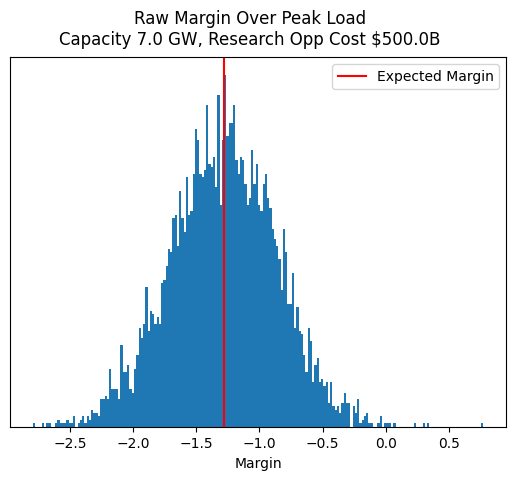

In [12]:
def plot_raw_margin(policy_params, n=5000):
    plt.figure()
    plt.suptitle(f"Raw Margin Over Peak Load\n"
                 f"Capacity {policy_params[0]} GW, "
                 f"Research Opp Cost ${policy_params[1]}B")
    margin_samples = tt([margin(model()).detach() for _ in range(n)])
    plt.hist(margin_samples, bins=200)
    plt.axvline(x=torch.mean(margin_samples), color='red', label=f"Expected Margin")
    plt.xlabel("Margin")
    plt.yticks([])
    plt.legend()
    # plt.show()
plot_raw_margin(pp)

In [13]:
PENALIZED_MARGIN_THRESH_GW = PMT = tt(0.85)

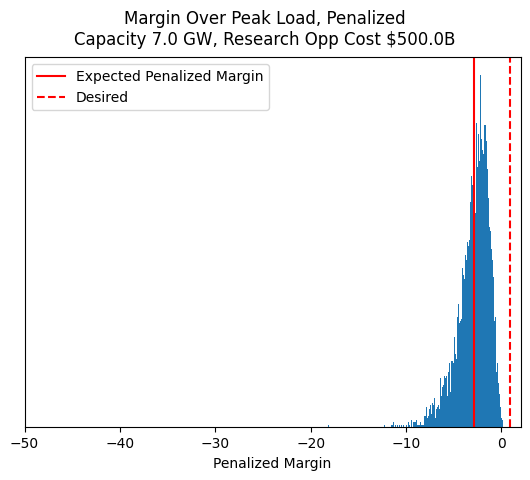

In [14]:
def plot_margin(xlim, policy_params, n=5000):
    plt.figure()
    plt.suptitle(f"Margin Over Peak Load, Penalized\n"
                 f"Capacity {policy_params[0]} GW, "
                 f"Research Opp Cost ${policy_params[1]}B")
    margin_samples = tt([penalized_margin(model()).detach() for _ in range(n)])
    plt.hist(margin_samples, bins=200)
    plt.axvline(x=torch.mean(margin_samples), color='red', label=f"Expected Penalized Margin")
    plt.xlabel("Penalized Margin")
    plt.yticks([])
    plt.axvline(x=PENALIZED_MARGIN_THRESH_GW, color='red', linestyle='dashed', label="Desired")
    plt.legend()
    plt.xlim((xlim, 2.))
    plt.show()
plot_margin(-50., pp)

In [15]:
# The policy objective is to minimize cost while keeping the expected penalized
#  margin below specified threshold.

tau_pmmdo = ep.C(tt(6e2))

# The deconstrained objective minimizes the cost and the degree
#  to which the expected penalized capacity sits below the
#  desired threshold.
penalized_margin_mean_deconstrained_objective = pmmdo = \
    ep.E(cost, "cost") \
    + tau_pmmdo * (ep.E(lambda s: -penalized_margin(s), "pmarg") + ep.C(PMT)).relu()
    # - tau_pmmdo * ep.E(penalized_margin, "pmarg")

##### Optimization


In [16]:
class DecisionOptimizer:
    def __init__(
            self,
            flat_dparams: PT,
            model: ep.typedecs.ModelType,
            cost: ep.ComposedExpectation,
            expectation_handler: ep.ExpectationHandler,
            lr: float
    ):
        self.flat_dparams = flat_dparams
        self.model = model
        # ep.ComposedExpectation objects can be auto-differentiated.
        self.cost_grad: ep.ComposedExpectation = cost.grad(self.flat_dparams) if cost is not None else None
        self.expectation_handler = expectation_handler
        self._lr = lr

        self.optim = torch.optim.SGD((self.flat_dparams,), lr=self._lr)

    @property
    def lr(self):
        return self._lr

    @lr.setter
    def lr(self, lr):
        self._lr = lr
        for g in self.optim.param_groups:
            g['lr'] = lr

    def estimate_grad(self):
        self.optim.zero_grad()
        self.flat_dparams.grad = None

        with self.expectation_handler:
            grad_estimate_: TT = self.cost_grad(self.model)

        return grad_estimate_

    def step_grad(self, grad_estimate_):
        self.flat_dparams.grad = grad_estimate_
        self.optim.step()

    def step(self):
        grad_estimate = self.estimate_grad()
        self.step_grad(grad_estimate)

In [17]:
pmmdo_opt = DecisionOptimizer(
    flat_dparams=pp,
    model=model,
    cost=penalized_margin_mean_deconstrained_objective,
    expectation_handler=ep.MonteCarloExpectationHandler(num_samples=1),
    lr=7e-2
)

capacity_param_pmmdo = []
research_param_pmmdo = []

In [18]:
N = MC_N = 5000
for i in range(N):
    grad_estimate = pmmdo_opt.estimate_grad()
    grad_estimate[1] *= 1e1
    grad_estimate[0] *= 2e-4
    pmmdo_opt.step_grad(grad_estimate)

    capacity_param_pmmdo.append(pp[0].item())
    research_param_pmmdo.append(pp[1].item())

In [19]:
def plot_parameter_optimization(capacity_param, research_param):

    fig, axs = plt.subplots(2, 1, sharex=True)

    axs[0].plot(capacity_param)
    axs[0].set_title("Capacity to Build")
    axs[1].plot(research_param)
    axs[1].set_title("Opp Cost of Research")

    plt.figure()
    plt.plot(capacity_param, research_param)
    plt.xlabel("Capacity to Build")
    plt.ylabel("Opp Cost of Research")

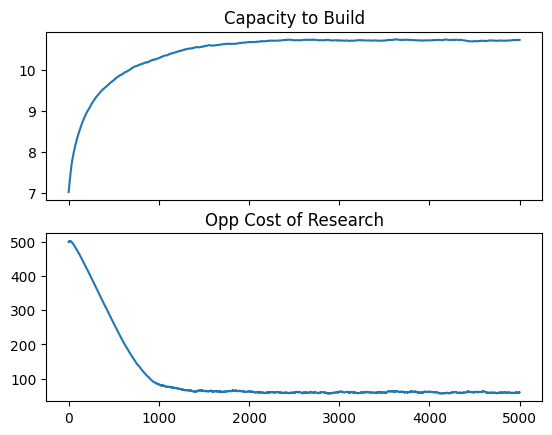

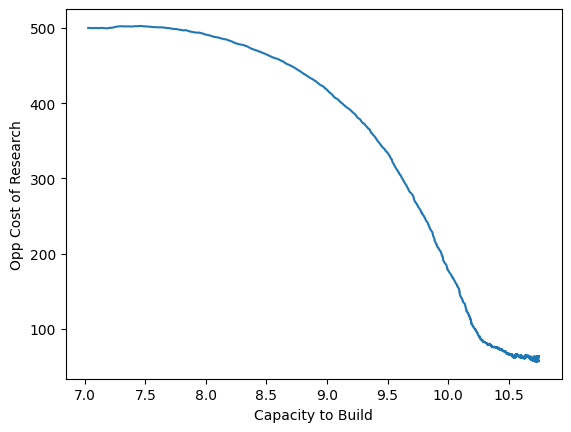

In [20]:
plot_parameter_optimization(capacity_param_pmmdo, research_param_pmmdo)

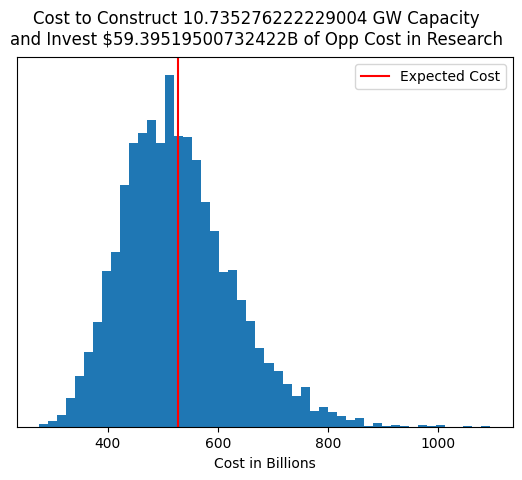

In [21]:
plot_cost(pp)

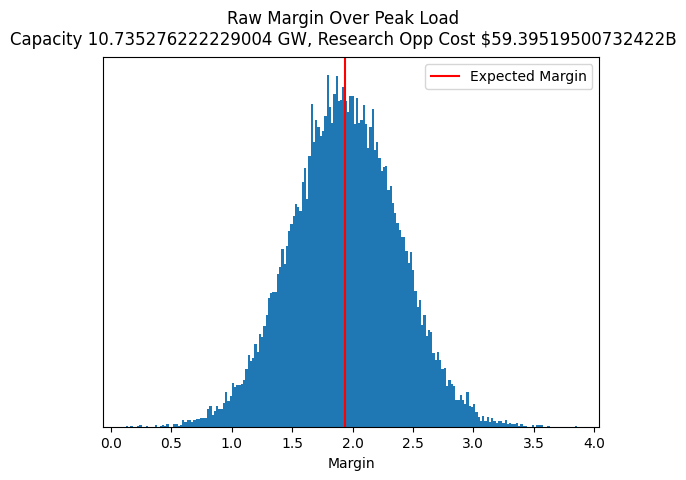

In [22]:
plot_raw_margin(pp, n=25000)

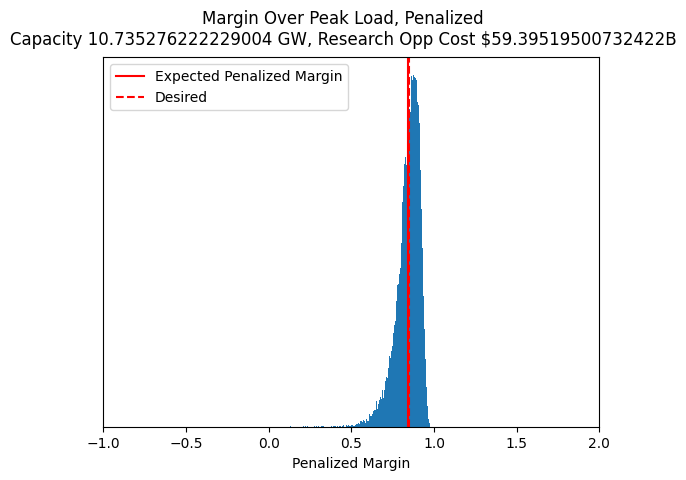

In [23]:
plot_margin(-1., pp, n=25000)

#### Threshold on Tail Expectation
Policy-makers want a more explicit knob to turn than the heuristic constraint on the expected penalized margin. Instead, they'd like the average margin of the scenarios with the worst margins to be above some threshold. They can formally define this constraint with the conditional value at risk (CVaR).

In [24]:
# Policy-makers are interested in scenarios in the worst alpha*100% (in terms of margin). But CVaR is traditionally concerned with larger numbers being the worst, so we need to invert this.
alpha = tt(1. - 0.1)

# The auxiliary variable, gamma. This initial
# value is derived from looking at the initial margin plot and eyballing the VaR.
# Again, CVaR is traditionally concerned with large being bad, so we
#  invert this.
gamma_init = -1. * -2.5

# The CVaR is the average margin of the worst alpha*100% of outcomes.
# Practitioners would like this to be above half a gigawatt.
# Again, we need to invert.
neg_margin_cvar_thresh = ep.C(tt(-1. * 0.5))

# The gamma auxiliary variable needs to eb combined with the other
# parameters, as the unconstrained formulation must optimize with respect
# to it as well.
pp_cvar = PT(tt([*(PP_OG.detach().clone().numpy()), gamma_init]))

# Rebuild with the new parameters.
cost = build_cost(pp_cvar)
margin = build_margin(pp_cvar)

In [25]:
# A current limitation of the `expectation_programming` package is that you cannot take gradients with respect to parameters outside
#  the functions inside the expectations. In the traditional unconstrained CVaR formulation, the gamma term appears twice — once
#  inside the expectation, and once outside. Due to current limitations, we need to push both inside.
def _margin_cvar(s):
    # Note that pp_cvar[-1] is the gamma parameter. Again note that we need to invert the margin so that large is bad.
    return (1. - alpha) * pp_cvar[-1] + ep.srelu((-margin(s)) - pp_cvar[-1])

expected_margin_cvar = ep.E(f=_margin_cvar, name="margin_cvar")

In [26]:
# Tau serves to balance the cost and margin penalty terms. Convergence to the constrained minimum hinges on this being the right value, which, in general
#  must be found by trial and error.
tau = tt(0.006)

In [27]:
# The cost remains unchanged.
expected_cost_cvar =  ep.E(f=cost, name="cost_cvar") * ep.C(tau)

In [28]:
alpha_factor = ep.C(1. / (1. - alpha))
expected_margin_cvar = ep.C(1. - tau) * (expected_margin_cvar * alpha_factor - neg_margin_cvar_thresh).relu()

In [29]:
# Combined, we have the following:
# 1) If a sample of latents results in a (-margin) less than gamma (which is initialized to 2.5), the _margin_cvar can be minimized by decreasing gamma (thereby including a larger number of samples for the case below.
# 2) If a sample of latents results in a (-margin) greater than gamma, then the margin can be reduced by increasing gamma (but this is penalized by the (1. - alpha) * gamma term), or decreasing (-margin(s)).
# 3) If that delta, scaled by the alpha_factor, exceeds the -margin_cvar_thresh of (-0.5), then the gradients will be surfaced to the optimizer. If it does not exceed the margin, then only cost will be minimized.

#### Comparing Convergence with MC vs. TABI Gradient Estimators

In [30]:
# We don't need use targeted estimation for the cost.
expected_cost_cvar_grad = expected_cost_cvar.grad(params=pp_cvar, split_atoms=False)
expected_margin_cvar_grad_tabi = expected_margin_cvar.grad(params=pp_cvar, split_atoms=True)
expected_margin_cvar_grad_mc = expected_margin_cvar.grad(params=pp_cvar, split_atoms=False)

margin_cvar_deconstrained_objective_tabi_grad = mcdo_tabi_grad = expected_cost_cvar_grad + expected_margin_cvar_grad_tabi
margin_cvar_deconstrained_objective_mc_grad = mcdo_mc_grad = expected_cost_cvar_grad + expected_margin_cvar_grad_mc

In [31]:
[p.name for p in mcdo_mc_grad.parts]

['dcost_cvar * 0.006000000052154064_dp0',
 'dcost_cvar * 0.006000000052154064_dp1',
 'dcost_cvar * 0.006000000052154064_dp2',
 'drelu(margin_cvar * 9.999998092651367 - -0.5)_dp0',
 'drelu(margin_cvar * 9.999998092651367 - -0.5)_dp1',
 'drelu(margin_cvar * 9.999998092651367 - -0.5)_dp2']

In [32]:
[p.name for p in mcdo_tabi_grad.parts]

['dcost_cvar * 0.006000000052154064_dp0',
 'dcost_cvar * 0.006000000052154064_dp1',
 'dcost_cvar * 0.006000000052154064_dp2',
 'drelu(margin_cvar * 9.999998092651367 - -0.5)_dp0_split_pos',
 'drelu(margin_cvar * 9.999998092651367 - -0.5)_dp0_split_neg',
 'drelu(margin_cvar * 9.999998092651367 - -0.5)_dp0_split_den',
 'drelu(margin_cvar * 9.999998092651367 - -0.5)_dp1_split_pos',
 'drelu(margin_cvar * 9.999998092651367 - -0.5)_dp1_split_neg',
 'drelu(margin_cvar * 9.999998092651367 - -0.5)_dp1_split_den',
 'drelu(margin_cvar * 9.999998092651367 - -0.5)_dp2_split_pos',
 'drelu(margin_cvar * 9.999998092651367 - -0.5)_dp2_split_neg',
 'drelu(margin_cvar * 9.999998092651367 - -0.5)_dp2_split_den']

##### MC Estimator

In [33]:
mcdo_mc_opt = DecisionOptimizer(
    flat_dparams=pp_cvar,
    model=model,
    cost=None,
    expectation_handler=ep.MonteCarloExpectationHandler(1),
    lr=1e-2
)
# TODO make DecisionOptimizer take cost or cost_grad directly.
mcdo_mc_opt.cost_grad = mcdo_mc_grad

In [34]:
capacity_params_mc_cvar = []
research_params_mc_cvar = []
gamma_params_mc_cvar = []

In [35]:
def manually_update_gamma(policy_params, n=1000, set_gamma=True):
    # HACK estimate gamma directly from samples. This will be the alpha'th percentile of the negative margin.
    _margin_estimates = tt([-margin(model()).detach() for _ in range(n)])
    _margin_estimates = _margin_estimates.sort()[0]
    gamma_estimate = _margin_estimates[int(alpha * _margin_estimates.shape[0])]
    if set_gamma:
        with torch.no_grad():
            policy_params[-1] = gamma_estimate
    # gt for cvar b/c inverted
    return gamma_estimate, _margin_estimates[_margin_estimates > gamma_estimate].mean()

In [36]:
manually_update_gamma(pp_cvar)

(tensor(1.7917), tensor(2.0273))

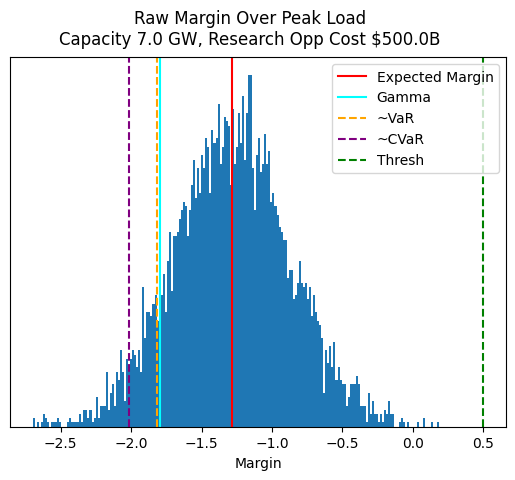

In [37]:
plot_raw_margin(pp_cvar)
plt.axvline(-pp_cvar[-1].item(), color="cyan", label="Gamma")
manual_var, manual_cvar = manually_update_gamma(pp_cvar, n=50000, set_gamma=False)
plt.axvline(-manual_var, color="orange", label="~VaR", linestyle='--')
plt.axvline(-manual_cvar, color="purple", label="~CVaR", linestyle='--')
plt.axvline(-neg_margin_cvar_thresh._const, color="green", label="Thresh", linestyle='--')
plt.legend()

In [38]:
N = 20000
for i in range(N):
    grad_estimate = mcdo_mc_opt.estimate_grad()
    grad_estimate[1] *= 6e3
    # grad_estimate[0] *= 2e-1
    # grad_estimate[2] *= 1e-1
    mcdo_mc_opt.step_grad(grad_estimate)

    # Hack to keep this manually up to date. This will confirm the rest of the machinery is working.
    # manually_update_gamma(pp_cvar)

    capacity_params_mc_cvar.append(pp_cvar[0].item())
    research_params_mc_cvar.append(pp_cvar[1].item())
    gamma_params_mc_cvar.append(pp_cvar[-1].item())

    print(f"Iteration {i}/{N} with Gamma {pp_cvar[-1].item():1.3f}", end="\r")

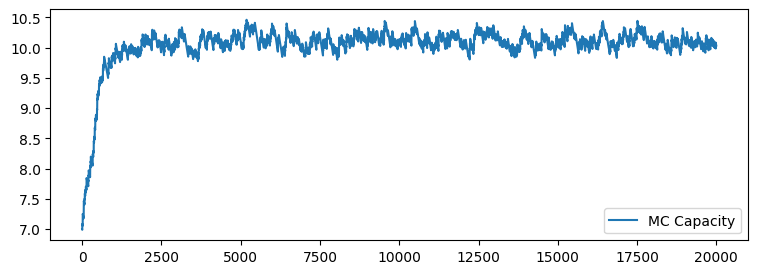

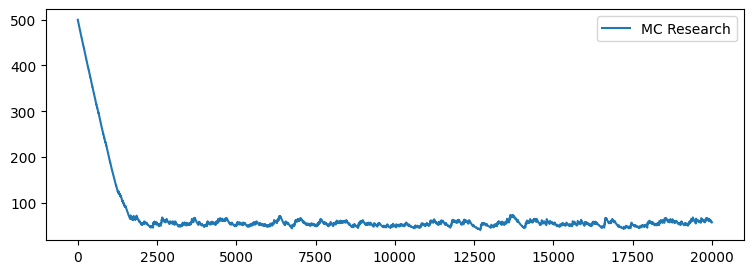

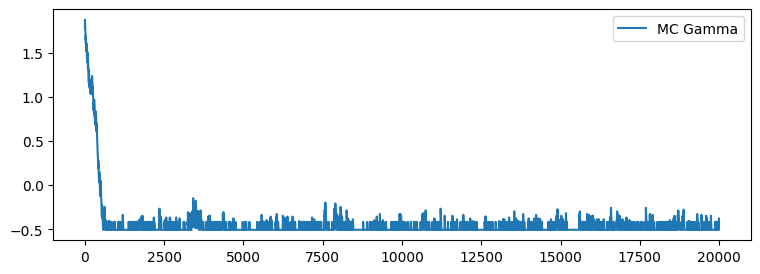

In [39]:
plt.subplots(figsize=(9, 3))
plt.plot(capacity_params_mc_cvar, label="MC Capacity")
plt.legend()
plt.subplots(figsize=(9, 3))
plt.plot(research_params_mc_cvar, label="MC Research")
plt.legend()
plt.subplots(figsize=(9, 3))
plt.plot(gamma_params_mc_cvar, label="MC Gamma")
plt.legend()

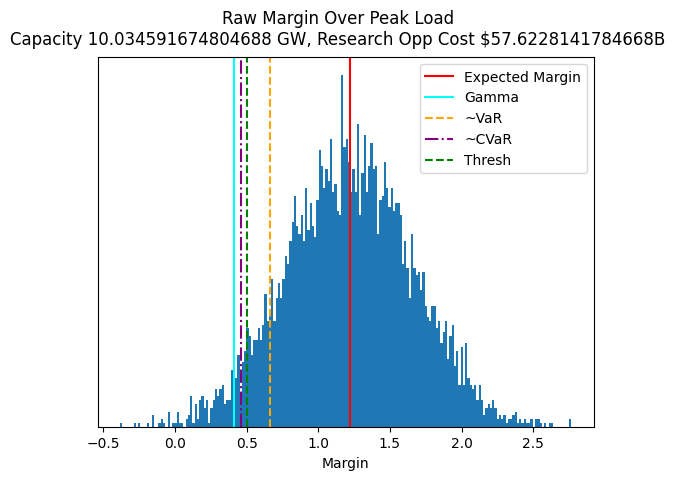

In [40]:
plot_raw_margin(pp_cvar)
plt.axvline(-pp_cvar[-1].item(), color="cyan", label="Gamma")
manual_var, manual_cvar = manually_update_gamma(pp_cvar, n=50000, set_gamma=False)
plt.axvline(-manual_var, color="orange", label="~VaR", linestyle='--')
plt.axvline(-manual_cvar, color="purple", label="~CVaR", linestyle='-.')
plt.axvline(-neg_margin_cvar_thresh._const, color="green", label="Thresh", linestyle='--')
plt.legend()

#### TABI Estimator

##### Guide (Proposal) Initialization

In [41]:
# The optimal denominating guides are actually all just the prior, since we aren't conditioning
#  on data here, and because the intervention does not affect the distribution over latent parameters.
#  Thus, we can swap all denominating guide out for the prior.
for p in expected_margin_cvar_grad_tabi.parts:
    if "den" in p.name:
        p.guide = model
    print(p.name, p.guide)

drelu(margin_cvar * 9.999998092651367 - -0.5)_dp0_split_pos None
drelu(margin_cvar * 9.999998092651367 - -0.5)_dp0_split_neg None
drelu(margin_cvar * 9.999998092651367 - -0.5)_dp0_split_den <function unmarginalized_model at 0x13fca31a0>
drelu(margin_cvar * 9.999998092651367 - -0.5)_dp1_split_pos None
drelu(margin_cvar * 9.999998092651367 - -0.5)_dp1_split_neg None
drelu(margin_cvar * 9.999998092651367 - -0.5)_dp1_split_den <function unmarginalized_model at 0x13fca31a0>
drelu(margin_cvar * 9.999998092651367 - -0.5)_dp2_split_pos None
drelu(margin_cvar * 9.999998092651367 - -0.5)_dp2_split_neg None
drelu(margin_cvar * 9.999998092651367 - -0.5)_dp2_split_den <function unmarginalized_model at 0x13fca31a0>


In [42]:
iseh_mcdo_tabi_grad = ep.ImportanceSamplingExpectationHandler(1)

iseh_mcdo_tabi_grad.register_guides(
    # Use importance sampling only on the constraint term.
    ce=expected_margin_cvar_grad_tabi,
    model=model,
    # auto_guide=pyro.infer.autoguide.AutoIAFNormal,
    # auto_guide_kwargs=dict(num_transforms=3)
    auto_guide=pyro.infer.autoguide.AutoMultivariateNormal,
    auto_guide_kwargs=dict(init_scale=1.0)
)

# Just use vanilla monte carlo for the cost. We'll use the iseh handler
#  above as the default, but will specify the MC handler for the cost.
expected_cost_cvar_grad.handler = ep.MonteCarloExpectationHandler(1)

In [43]:
[(p.name, iseh_mcdo_tabi_grad.guides[p.name]) for p in expected_margin_cvar_grad_tabi.parts]

[('drelu(margin_cvar * 9.999998092651367 - -0.5)_dp0_split_pos',
  AutoMultivariateNormal()),
 ('drelu(margin_cvar * 9.999998092651367 - -0.5)_dp0_split_neg',
  AutoMultivariateNormal()),
 ('drelu(margin_cvar * 9.999998092651367 - -0.5)_dp0_split_den',
  <function __main__.unmarginalized_model()>),
 ('drelu(margin_cvar * 9.999998092651367 - -0.5)_dp1_split_pos',
  AutoMultivariateNormal()),
 ('drelu(margin_cvar * 9.999998092651367 - -0.5)_dp1_split_neg',
  AutoMultivariateNormal()),
 ('drelu(margin_cvar * 9.999998092651367 - -0.5)_dp1_split_den',
  <function __main__.unmarginalized_model()>),
 ('drelu(margin_cvar * 9.999998092651367 - -0.5)_dp2_split_pos',
  AutoMultivariateNormal()),
 ('drelu(margin_cvar * 9.999998092651367 - -0.5)_dp2_split_neg',
  AutoMultivariateNormal()),
 ('drelu(margin_cvar * 9.999998092651367 - -0.5)_dp2_split_den',
  <function __main__.unmarginalized_model()>)]

In [44]:
import re

def visualize_iseh_guides(iseh_: ep.ImportanceSamplingExpectationHandler, keys=None):
    if keys is None:
        keys = sorted(iseh_.keys())

    fig, axs = plt.subplots(len(keys) // 3, 3, figsize=(3*4, len(keys) // 3*4), sharex=True, sharey=True)

    for ax, key in zip(axs.flatten(), keys):
        print("Visualizing ", key)
        iseh_.plot_guide_pseudo_likelihood_2d(
            rv1_name='rpl',
            rv2_name='rcs',
            ax=ax,
            key=key,
            n=2000,
            resolution=25,
            guide_scatter_kwargs=dict(color='white', alpha=0.2, s=0.4),
            model_contour_kwargs=dict(colors='orange', levels=6, linewidths=0.8)
        )
        ax.set_title(re.sub(r'\d+\.\d+', '#', key))

        # Set the background color of the plot to gray.
        ax.set_facecolor('gray')

In [45]:
# Reset the parameters.
with torch.no_grad():
    pp_cvar[:] = tt([*PP_OG.detach().clone().numpy(), gamma_init])
manually_update_gamma(pp_cvar)

(tensor(1.8016), tensor(1.9654))

In [46]:
RELU_SOFTENING = tt(0.01)
with ep.FillReluAtLevelExp(beta=RELU_SOFTENING):
    losses = iseh_mcdo_tabi_grad.optimize_guides(
            lr=1e-3,
            n_steps=30000,
            adjust_grads_=None,
            callback=None,
            keys=[k for k in iseh_mcdo_tabi_grad.keys() if ("den" not in k)]
        )

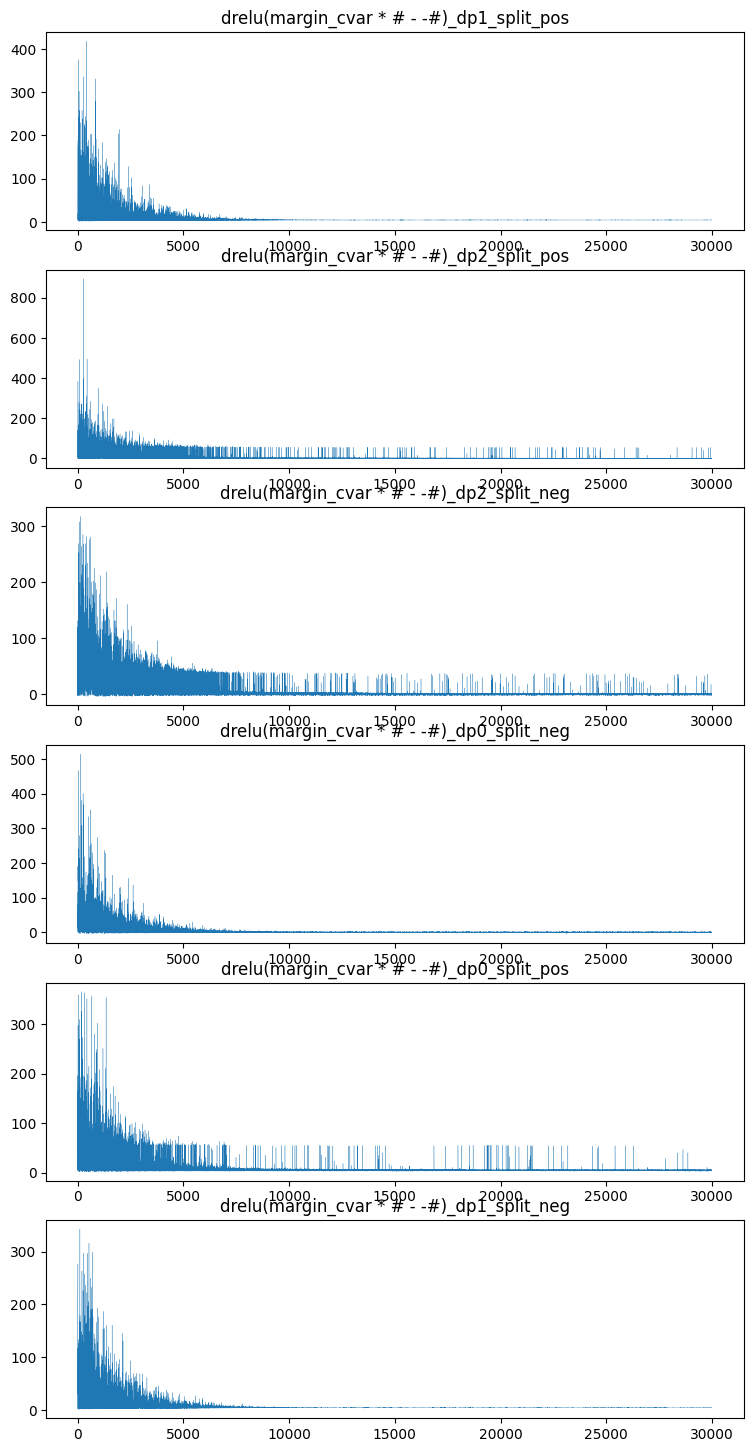

In [47]:
fig, axs = plt.subplots(nrows=len(losses), ncols=1, figsize=(9, 3 * len(losses)))
for ax, (k, vv) in zip(axs, losses.items()):
    ax.set_title(re.sub(r'\d+\.\d+', '#', k))
    ax.plot([v.detach() for v in vv[:]], linewidth=0.2)

Visualizing  drelu(margin_cvar * 9.999998092651367 - -0.5)_dp0_split_den
Visualizing  drelu(margin_cvar * 9.999998092651367 - -0.5)_dp0_split_neg
Visualizing  drelu(margin_cvar * 9.999998092651367 - -0.5)_dp0_split_pos
Visualizing  drelu(margin_cvar * 9.999998092651367 - -0.5)_dp1_split_den
Visualizing  drelu(margin_cvar * 9.999998092651367 - -0.5)_dp1_split_neg
Visualizing  drelu(margin_cvar * 9.999998092651367 - -0.5)_dp1_split_pos
Visualizing  drelu(margin_cvar * 9.999998092651367 - -0.5)_dp2_split_den
Visualizing  drelu(margin_cvar * 9.999998092651367 - -0.5)_dp2_split_neg
Visualizing  drelu(margin_cvar * 9.999998092651367 - -0.5)_dp2_split_pos


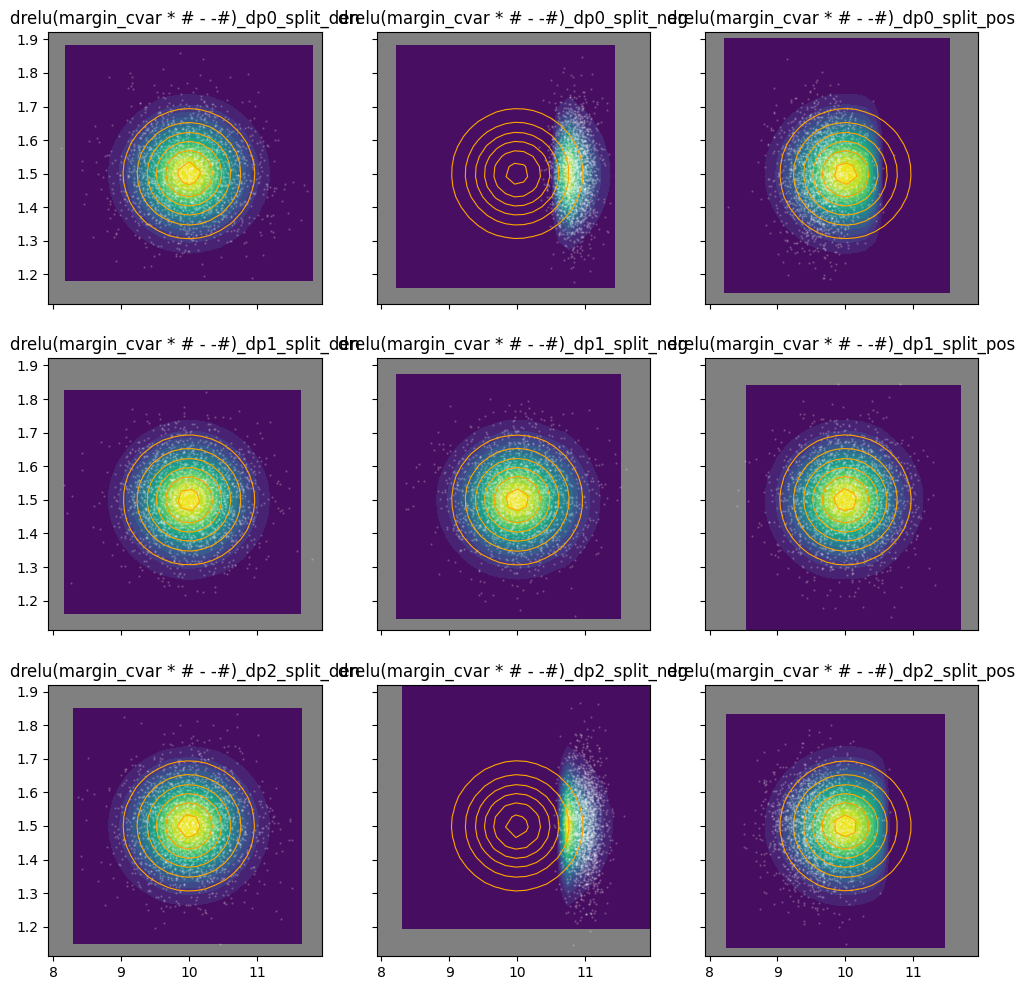

In [48]:
with ep.FillReluAtLevelExp(beta=RELU_SOFTENING):
    visualize_iseh_guides(iseh_mcdo_tabi_grad)

Visualizing  drelu(margin_cvar * 9.999998092651367 - -0.5)_dp0_split_den
Visualizing  drelu(margin_cvar * 9.999998092651367 - -0.5)_dp0_split_neg
Visualizing  drelu(margin_cvar * 9.999998092651367 - -0.5)_dp0_split_pos
Visualizing  drelu(margin_cvar * 9.999998092651367 - -0.5)_dp1_split_den
Visualizing  drelu(margin_cvar * 9.999998092651367 - -0.5)_dp1_split_neg
Visualizing  drelu(margin_cvar * 9.999998092651367 - -0.5)_dp1_split_pos
Visualizing  drelu(margin_cvar * 9.999998092651367 - -0.5)_dp2_split_den
Visualizing  drelu(margin_cvar * 9.999998092651367 - -0.5)_dp2_split_neg
Visualizing  drelu(margin_cvar * 9.999998092651367 - -0.5)_dp2_split_pos


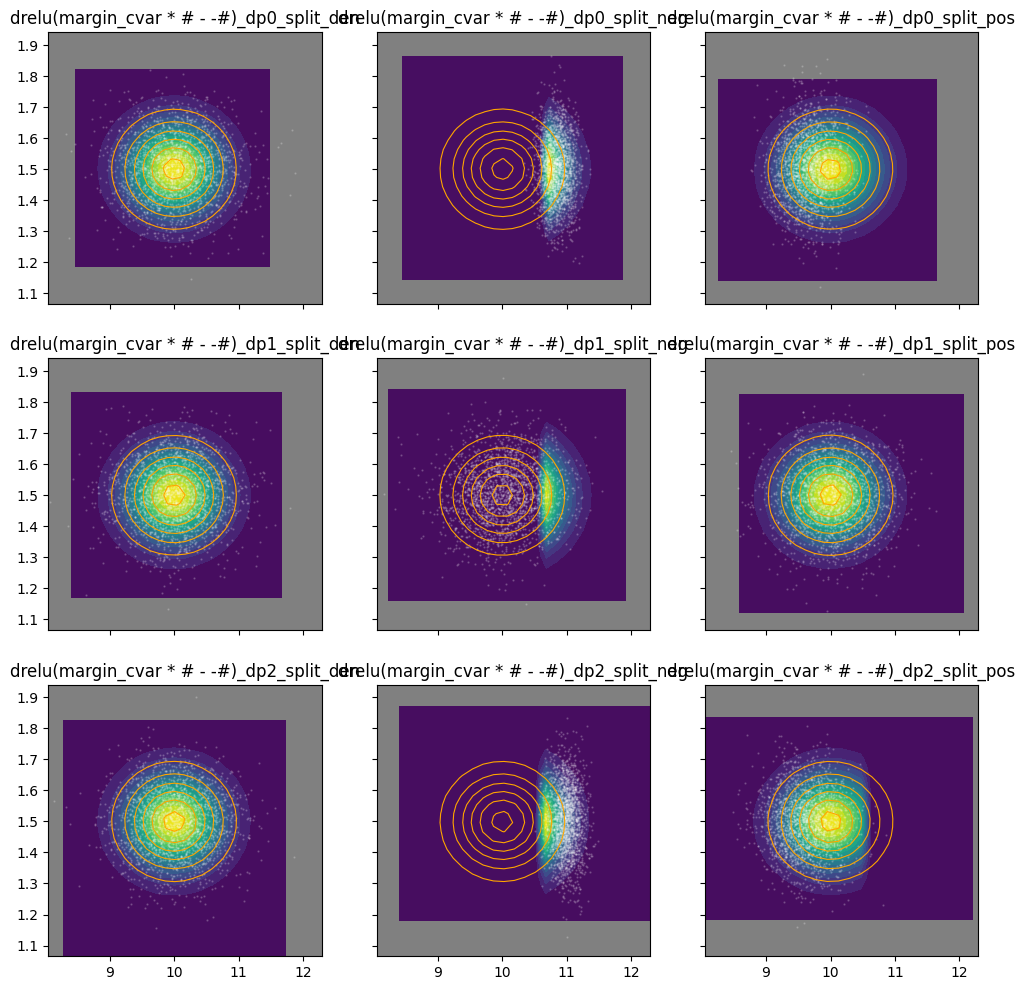

In [49]:
visualize_iseh_guides(iseh_mcdo_tabi_grad)

In [50]:
import numpy as np
# Smoke test the full estimation process.
iseh_mcdo_tabi_grad.num_samples = 1
with iseh_mcdo_tabi_grad:
    smoke_test_samples_tabi = np.array([mcdo_tabi_grad(model).detach().numpy() for _ in range(10000)])

In [51]:
with ep.MonteCarloExpectationHandler(1):
    smoke_test_samples_mc = np.array([mcdo_mc_grad(model).detach().numpy() for _ in range(10000)])

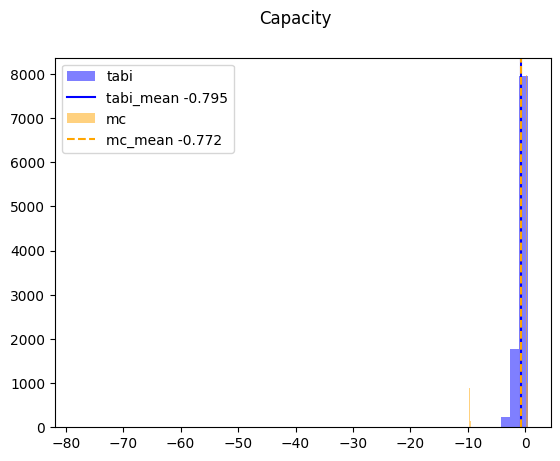

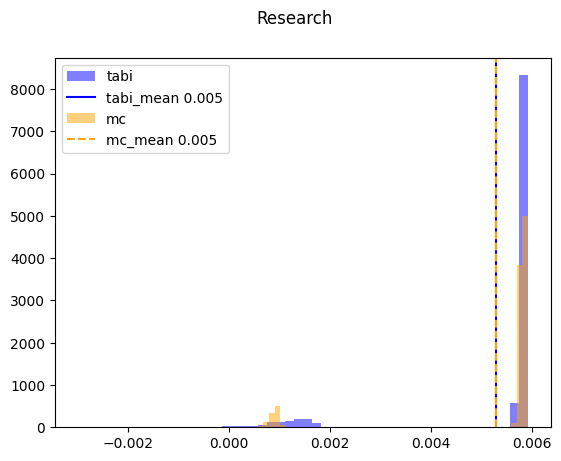

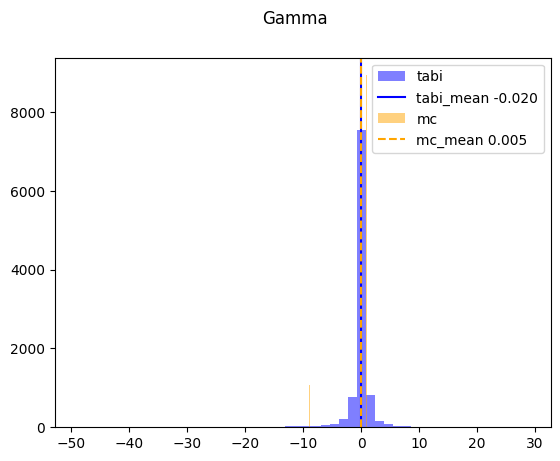

In [52]:
bins = 50
plt.figure()
plt.suptitle("Capacity")
plt.hist(smoke_test_samples_tabi[:, 0], bins=bins, label="tabi", alpha=0.5, color="blue")
tabi_mean_0 = smoke_test_samples_tabi[:, 0].mean()
plt.axvline(tabi_mean_0, label=f"tabi_mean {tabi_mean_0:1.3f}", color="blue")
plt.hist(smoke_test_samples_mc[:, 0], bins=bins, label="mc", alpha=0.5, color="orange")
mc_mean_0 = smoke_test_samples_mc[:, 0].mean()
plt.axvline(mc_mean_0, label=f"mc_mean {mc_mean_0:1.3f}", linestyle='--', color="orange")
plt.legend()
plt.figure()
plt.suptitle("Research")
plt.hist(smoke_test_samples_tabi[:, 1], bins=bins, label="tabi", alpha=0.5, color="blue")
tabi_mean_1 = smoke_test_samples_tabi[:, 1].mean()
plt.axvline(tabi_mean_1, label=f"tabi_mean {tabi_mean_1:1.3f}", color="blue")
plt.hist(smoke_test_samples_mc[:, 1], bins=bins, label="mc", alpha=0.5, color="orange")
mc_mean_1 = smoke_test_samples_mc[:, 1].mean()
plt.axvline(mc_mean_1, label=f"mc_mean {mc_mean_1:1.3f}", linestyle='--', color="orange")
plt.legend()
plt.figure()
plt.suptitle("Gamma")
plt.hist(smoke_test_samples_tabi[:, 2], bins=bins, label="tabi", alpha=0.5, color="blue")
tabi_mean_3 = smoke_test_samples_tabi[:, 2].mean()
plt.axvline(tabi_mean_3, label=f"tabi_mean {tabi_mean_3:1.3f}", color="blue")
plt.hist(smoke_test_samples_mc[:, 2], bins=bins, label="mc", alpha=0.5, color="orange")
mc_mean_3 = smoke_test_samples_mc[:, 1].mean()
plt.axvline(mc_mean_3, label=f"mc_mean {mc_mean_3:1.3f}", linestyle='--', color="orange")
plt.legend()

##### Optimization

In [53]:
mcdo_tabi_opt = DecisionOptimizer(
    flat_dparams=pp_cvar,
    model=model,
    cost=None,
    expectation_handler=iseh_mcdo_tabi_grad,
    lr=mcdo_mc_opt.lr
)
# TODO make DecisionOptimizer take cost or cost_grad directly.
mcdo_tabi_opt.cost_grad = mcdo_tabi_grad

In [54]:
capacity_params_tabi_cvar = []
research_params_tabi_cvar = []
gamma_params_tabi_cvar = []

In [55]:
N = 5000
for i in range(N):
    grad_estimate = mcdo_tabi_opt.estimate_grad()
    grad_estimate[1] *= 6e3
    # grad_estimate[0] *= 2e-1
    # grad_estimate[2] *= 1e-1
    mcdo_tabi_opt.step_grad(grad_estimate)

    if i % 10 == 0:
        with ep.FillReluAtLevelExp(beta=RELU_SOFTENING):
            iseh_mcdo_tabi_grad.optimize_guides(
                lr=1e-3,
                n_steps=50,
                adjust_grads_=None,
                callback=None,
                keys=[k for k in iseh_mcdo_tabi_grad.keys() if ("den" not in k)]
            )

    capacity_params_tabi_cvar.append(pp_cvar[0].item())
    research_params_tabi_cvar.append(pp_cvar[1].item())
    gamma_params_tabi_cvar.append(pp_cvar[2].item())

    print(f"Iteration {i}/{N} with Gamma {pp_cvar[-1].item():1.3f}", end="\r")

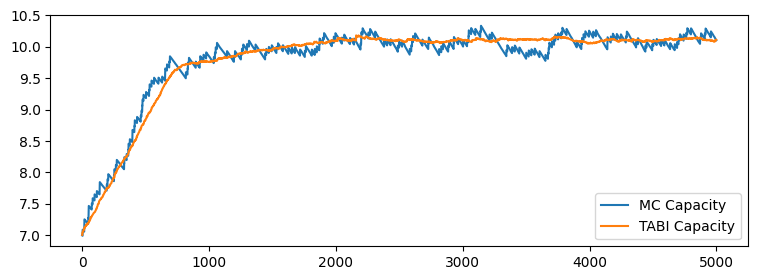

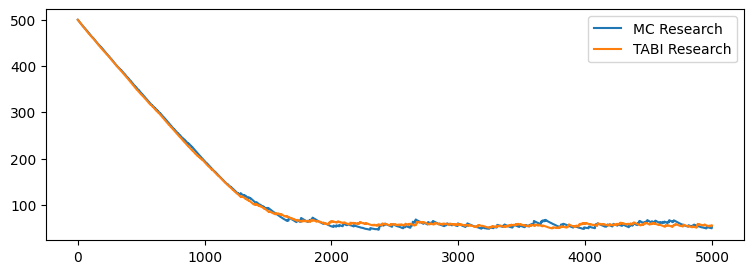

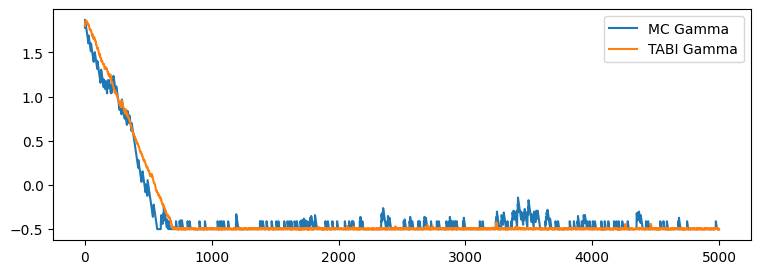

In [61]:
plt.subplots(figsize=(9, 3))
plt.plot(capacity_params_mc_cvar[:5000], label="MC Capacity")
plt.plot(capacity_params_tabi_cvar[:5000], label="TABI Capacity")
plt.legend()
plt.subplots(figsize=(9, 3))
plt.plot(research_params_mc_cvar[:5000], label="MC Research")
plt.plot(research_params_tabi_cvar[:5000], label="TABI Research")
plt.legend()
plt.subplots(figsize=(9, 3))
plt.plot(gamma_params_mc_cvar[:5000], label="MC Gamma")
plt.plot(gamma_params_tabi_cvar[:5000], label="TABI Gamma")
plt.legend()

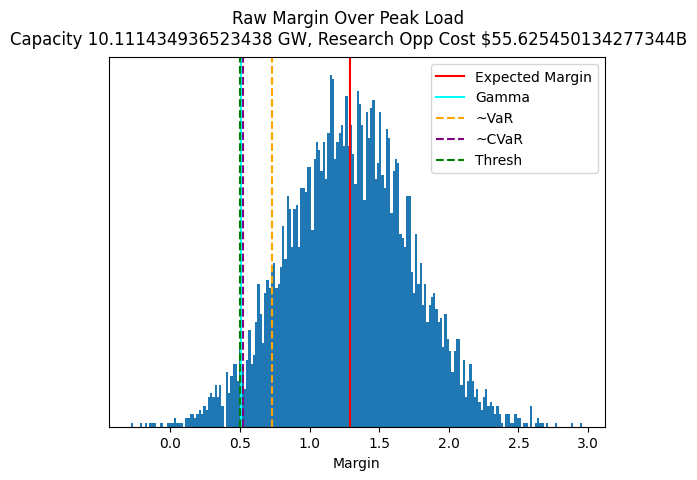

In [57]:
plot_raw_margin(pp_cvar)
plt.axvline(-pp_cvar[-1].item(), color="cyan", label="Gamma")
manual_var, manual_cvar = manually_update_gamma(pp_cvar, n=50000, set_gamma=False)
plt.axvline(-manual_var, color="orange", label="~VaR", linestyle='--')
plt.axvline(-manual_cvar, color="purple", label="~CVaR", linestyle='--')
plt.axvline(-neg_margin_cvar_thresh._const, color="green", label="Thresh", linestyle='--')
plt.legend()

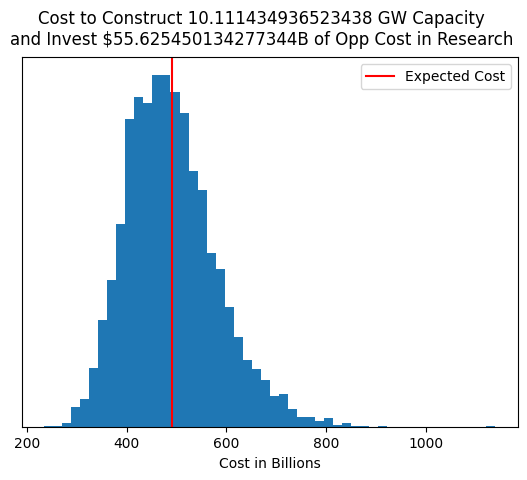

In [58]:
plot_cost(pp_cvar)

Visualizing  drelu(margin_cvar * 9.999998092651367 - -0.5)_dp0_split_den
Visualizing  drelu(margin_cvar * 9.999998092651367 - -0.5)_dp0_split_neg
Visualizing  drelu(margin_cvar * 9.999998092651367 - -0.5)_dp0_split_pos
Visualizing  drelu(margin_cvar * 9.999998092651367 - -0.5)_dp1_split_den
Visualizing  drelu(margin_cvar * 9.999998092651367 - -0.5)_dp1_split_neg
Visualizing  drelu(margin_cvar * 9.999998092651367 - -0.5)_dp1_split_pos
Visualizing  drelu(margin_cvar * 9.999998092651367 - -0.5)_dp2_split_den
Visualizing  drelu(margin_cvar * 9.999998092651367 - -0.5)_dp2_split_neg
Visualizing  drelu(margin_cvar * 9.999998092651367 - -0.5)_dp2_split_pos


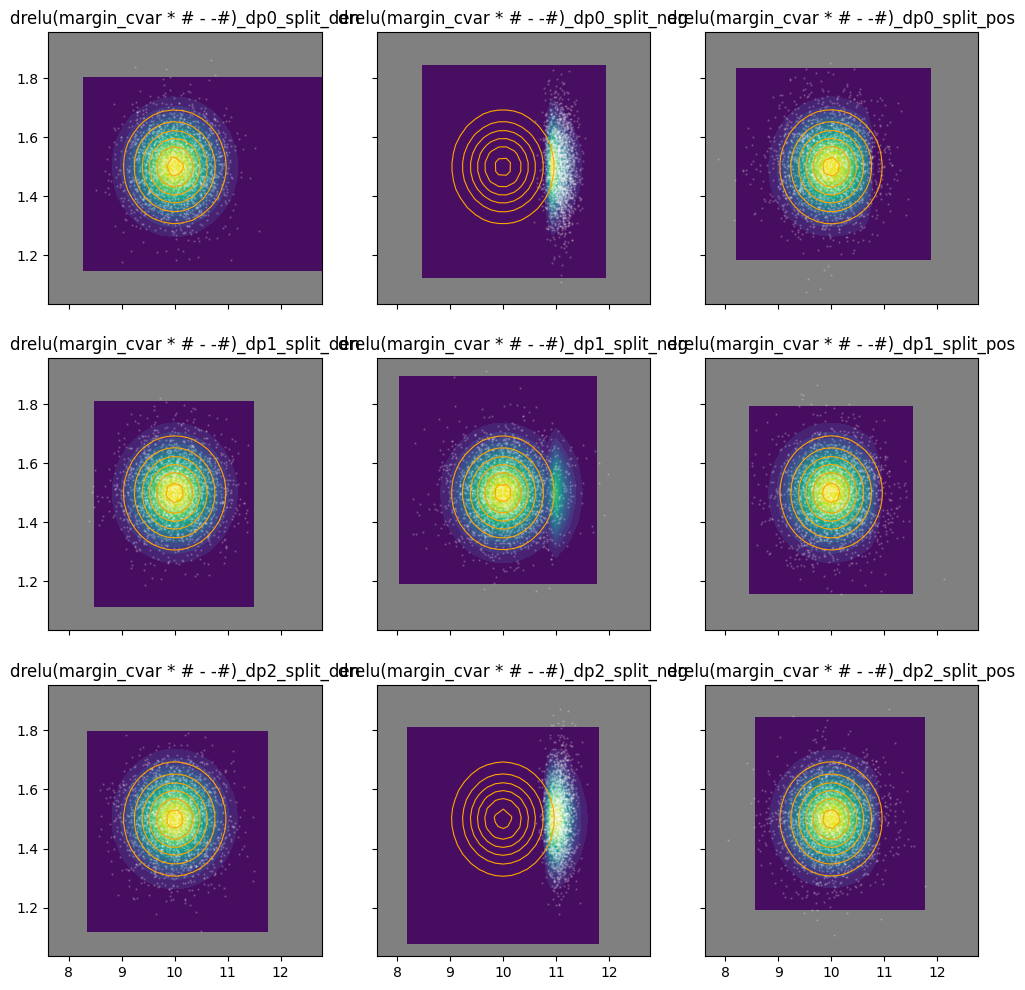

In [59]:
with ep.FillReluAtLevelExp(beta=RELU_SOFTENING):
    visualize_iseh_guides(iseh_mcdo_tabi_grad)

Visualizing  drelu(margin_cvar * 9.999998092651367 - -0.5)_dp0_split_den
Visualizing  drelu(margin_cvar * 9.999998092651367 - -0.5)_dp0_split_neg
Visualizing  drelu(margin_cvar * 9.999998092651367 - -0.5)_dp0_split_pos
Visualizing  drelu(margin_cvar * 9.999998092651367 - -0.5)_dp1_split_den
Visualizing  drelu(margin_cvar * 9.999998092651367 - -0.5)_dp1_split_neg
Visualizing  drelu(margin_cvar * 9.999998092651367 - -0.5)_dp1_split_pos
Visualizing  drelu(margin_cvar * 9.999998092651367 - -0.5)_dp2_split_den
Visualizing  drelu(margin_cvar * 9.999998092651367 - -0.5)_dp2_split_neg
Visualizing  drelu(margin_cvar * 9.999998092651367 - -0.5)_dp2_split_pos


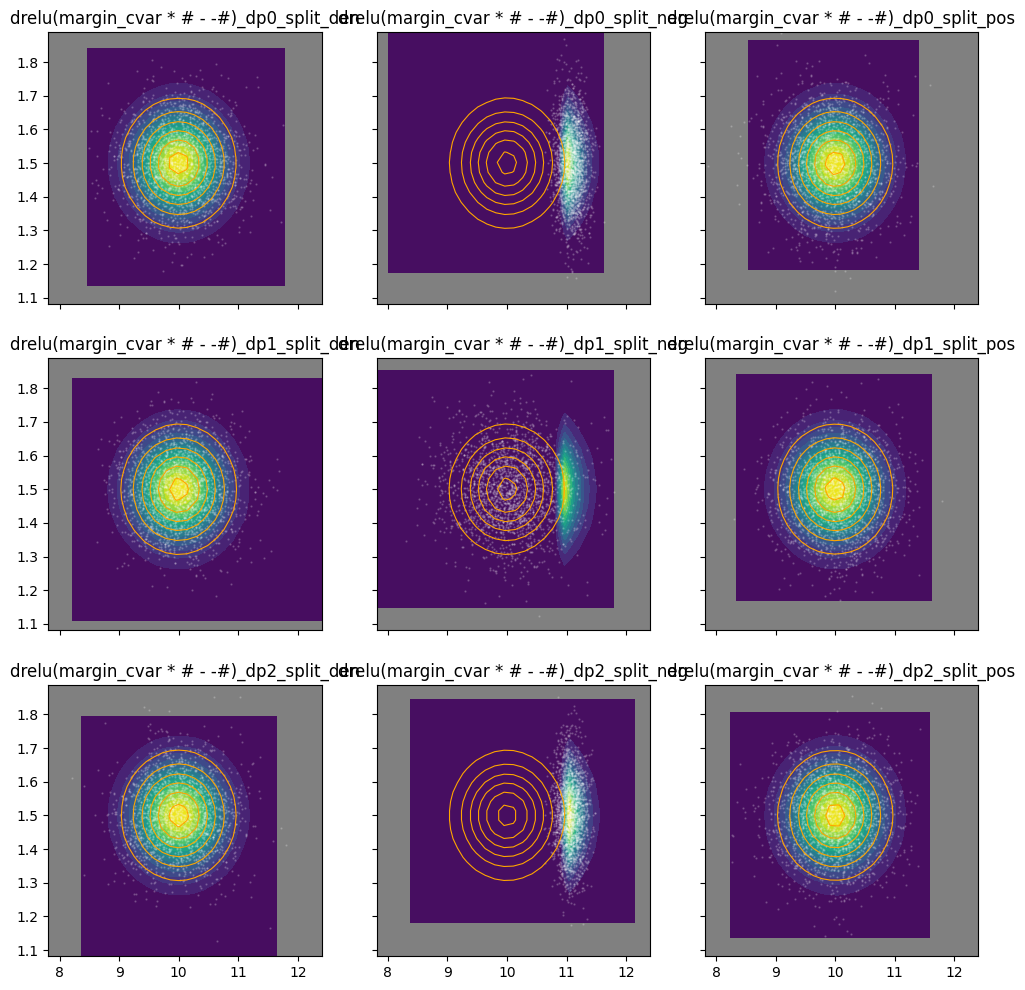

In [60]:
visualize_iseh_guides(iseh_mcdo_tabi_grad)